In [3]:
!pip install cvxpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.1/849.1 KB 16.6 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.0/89.0 KB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.5/249.5 KB 5.5 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 19.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.4/87.4 KB 3.2 MB/s eta 0:00:00


In [5]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import math
import random
import pandas as pd

import seaborn as sns
from __future__ import division
import time
from cvxpy import *


%matplotlib inline

In [6]:
sns.set_style({'axes.linewidth': 1, 'axes.edgecolor':'black', 'xtick.direction': \
               'out', 'xtick.major.size': 4.0, 'ytick.direction': 'out', 'ytick.major.size': 4.0, \
              'axes.facecolor': 'white','grid.color': '.8', 'grid.linestyle': u'-', 'grid.linewidth': 0.5})

In [22]:


Battery_Data = pd.read_csv('./BattData.csv')

# get_all_values gives a list of rows.


battdata = np.array(Battery_Data.values)

bat_ID = battdata[:,0]
B_bar = battdata[:,1]
B_P = battdata[:,2]
eta_b_c = battdata[:,3]
eta_b_d = battdata[:,4]
print(Battery_Data)





    ID  B_bar    B_P  eta_b_c  eta_b_d
0    1    200   50.0     0.95     0.95
1    2    300   75.0     0.95     0.95
2    3    600  150.0     0.95     0.95
3    4    100   25.0     0.95     0.95
4    5    100   25.0     0.95     0.95
5    6     10    2.5     0.95     0.95
6    7   1500  375.0     0.95     0.95
7    8    400  100.0     0.95     0.95
8    9     10    2.5     0.95     0.95
9   10    100   25.0     0.95     0.95
10  11    300   75.0     0.95     0.95
11  12   1200  300.0     0.95     0.95
12  13     20    5.0     0.95     0.95
13  14   3000  750.0     0.95     0.95
14  15    800  200.0     0.95     0.95


In [21]:
#Select Batteries being used in model; ID corresponds to row
ID=1
BattParam=Battery_Data.loc[ID-1] 
print(BattParam)


ID           1.00
B_bar      200.00
B_P         50.00
eta_b_c      0.95
eta_b_d      0.95
Name: 0, dtype: float64


In [23]:
class Battery(object):
    """ Used to store information about the battery.
       :param current_charge: is the initial state of charge of the battery
       :param capacity: is the battery capacity in kWh
       :param charging_power_limit: the limit of the power that can charge the battery in kW
       :param discharging_power_limit: the limit of the power that can discharge the battery in kW
       :param battery_charging_efficiency: The efficiecny of the battery when charging
       :param battery_discharing_efficiecny: The discharging efficiency
    """
    def __init__(self,
                 current_charge=0.0,
                 capacity=0.0,
                 charging_power_limit=1.0,
                 discharging_power_limit=-1.0,
                 charging_efficiency=0.95,
                 discharging_efficiency=0.95):
        self.current_charge = current_charge
        self.capacity = capacity
        self.charging_power_limit = charging_power_limit
        self.discharging_power_limit = discharging_power_limit
        self.charging_efficiency = charging_efficiency
        self.discharging_efficiency = discharging_efficiency

In [24]:
batt_id = 1
# use battery class to store information
batt = Battery(capacity=BattParam["B_bar"], charging_power_limit=BattParam["B_P"], 
               discharging_power_limit=-1*BattParam["B_P"], 
               charging_efficiency=BattParam["eta_b_c"], 
               discharging_efficiency=BattParam["eta_b_d"])

batt.capacity

200.0

In [26]:
User_PV_Data = pd.read_csv('./Solar_Demand.csv')

# get_all_values gives a list of rows.


userdata = np.array(User_PV_Data.values)


print(User_PV_Data)

     Time  PV_Output  Demand_kW  Grid_Cost
0    0:00        0.0       0.12       0.01
1    0:15        0.0       0.12       0.01
2    0:30        0.0       0.12       0.01
3    0:45        0.0       0.12       0.01
4    1:00        0.0       0.16       0.01
..    ...        ...        ...        ...
91  22:45        0.0       0.20       0.01
92  23:00        0.0       0.16       0.01
93  23:15        0.0       0.16       0.01
94  23:30        0.0       0.16       0.01
95  23:45        0.0       0.16       0.01

[96 rows x 4 columns]


In [27]:
Demand_kW = userdata[:,2]
PV_Output = userdata[:,1]
Grid_Cost = userdata[:,3]




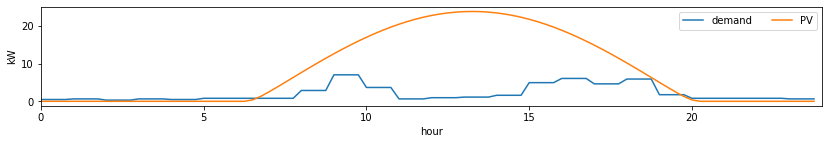

In [28]:
colors = sns.color_palette()
hrs = np.arange(0,len(Demand_kW))/4
fig = plt.figure(figsize=(14,4))
ax1 = fig.add_subplot(2,1,1)
l1, = ax1.plot(hrs,4*Demand_kW,color=colors[0])
l2, = ax1.plot(hrs,4*PV_Output,color=colors[1])
ax1.set_xlabel('hour'), ax1.set_ylabel('kW')
ax1.legend([l1,l2],['demand','PV'],ncol=2)
ax1.set_xlim([0,PV_Output.shape[0]/4]);

In [35]:
# Simulate running time
start=time.time()
# Three cases considered: Peak, lowest and average solar gains
# Peak
# title="High solar irradiance -"
# start_day=195
# end_day=198
# start_day=207
# end_day=210
# Lowest
# title="Low solar irradiance -"
# start_day=69
# end_day=72
# Average
title="Average solar irradiance -"
start_day=12
end_day=24
# Number of hours in the whole simulation
n_hours = (end_day-start_day+1)*24


In [36]:


#  generation cost

c_s = 0.00774*n_hours*0.220 # US/array
cf_b = 0.00229*n_hours # US/kWh/hour

# Emissions factor
ef_d = 1940 #(gCO2/kWh)
ef_b = 120 #(gCO2/kWh)
ef_s = 64 #(gCO2/kWh)

In [37]:
p_d_max = Variable() # 1 dimension
p_d = Variable(n_hours) # same length as number of hours
n_s = Variable() # 1 dimension
Q = Variable() # 1 dimension
p_b = Variable(n_hours) # same length as number of hours
# Total power provided by solar irradiation is the product of number of array
# and power provided by each array
p_s = n_s*np.array(PV_Output)
#---------------Optimization function------------#
# Objective function is to minimize cost. First three terms are fixed costs and
# last term is variable cost
objective= Minimize(c_s*n_s + cf_b*Q)

n_s

Variable(())

In [38]:
#----------------Constraints-------------------#


# Battery
for h in range (n_hours):
 # The battery discharge at any time is less than the total battery charge up to
 # that time
 constraints = [p_b[h] <= sum(-p_b[:h]) + Q/2]

 # The total charge of the battery at any time (including its 50% initial charge)
 # must be smaller than or equal to its maximum capacity
 constraints += [sum(-p_b[:h]) + Q/2 <= Q]

 # The total charge of the battery at any time (including its 50% initial charge)
 # must be greater than or equal to zero
 constraints += [sum(-p_b[:h]) + Q/2 >= 0]
 
 
prob1 = Problem(objective,constraints)
prob1.solve()
end = time.time()


print("Cost($/day)= %1.2f"%(prob1.n_hours*24))
print("Number of arrays= ", n_s.value)
print("Battery capacity (kWh)=",Q.value)

print("Running time= %1.2f"%(end-start))




AttributeError: 'Problem' object has no attribute 'n_hours'

In [ ]:
#battery SOC
SOC_value=np.array([])
for h in range (n_hours):
 SOC_value=np.append(SOC_value, -p_b.value[:h].sum()+Q.value/2)

TypeError: ignored

In [ ]:
# Plot Data
plt.figure(num=1, figsize=(8, 9), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(2,1,1)
plt.title(title + " Electricity generation and battery state of charge - Nb of days=
%1.f"%(n_hours/24))
# Plot table
plt.plot(np.arange(n_hours),pc.sum(1)[:n_hours],color="black", label='Consumption')
plt.plot(np.arange(n_hours),p_d.value[:n_hours],color="grey", label='Diesel')
plt.plot(np.arange(n_hours),pos(p_b).value[:n_hours],color="green", label='BatteryDischarging')

plt.plot(np.arange(n_hours),-neg(p_b).value[:n_hours],color="green",
linestyle='dashed', label='Battery-Charging')
plt.plot(np.arange(n_hours),p_s.value[:n_hours],color="orange", label='Solar')
plt.legend()
plt.ylabel("Generation sources (kW)")
plt.subplot(2,1,2)
# Plot
plt.plot(np.arange(n_hours),SOC_value[:n_hours],color="red", label='SOC')
plt.xlabel("Time (h)")
plt.ylabel("Battery charging (kWh)")
plt.show()

SyntaxError: ignored